https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

Using TensorFlow backend.


### Data Paths

In [2]:
data_path = '~/Desktop/kaggle/Grocery/data/'
Holiday_Events = pd.read_csv(data_path + 'holidays_events.csv')
Items = pd.read_csv(data_path + 'items.csv')
Oil = pd.read_csv(data_path + 'oil.csv')
Sample_Submission = pd.read_csv(data_path + 'sample_submission.csv')
Stores = pd.read_csv(data_path + 'stores.csv')
Test = pd.read_csv(data_path + 'test.csv')
Transactions = pd.read_csv(data_path + 'transactions.csv')

### Data Prep Helper Functions

In [12]:
#Data Prep functions
def prep_data(dataset):
    start_dt = '1/2/2013'
    end_dt = '8/15/2017'
    dataset = dataset[['date','store_nbr','unit_sales','onpromotion']]
    dt_rng = pd.date_range(start = start_dt, end = end_dt, freq='D')
    day = pd.DataFrame({'day': dt_rng.dayofweek})
    dt_rng = pd.to_datetime(dt_rng)
    dt_rng = pd.DataFrame({'date': dt_rng.strftime('%Y-%m-%d'),
                          'day': dt_rng.dayofweek})
    stores = pd.DataFrame({'store_nbr':pd.Series(range(1,54))})
    dataset_calendar = cartesian_product(dt_rng, stores)
    dataset = pd.merge(dataset_calendar, dataset, how = 'left', on=['date','store_nbr'])
    #impute
    #Set weekends to 0
    dataset.loc[(dataset['day']==5) | (dataset['day']==6),'unit_sales'] = 0
    dataset.loc[(dataset['day']==5) | (dataset['day']==6),'onpromotion'] = False
    
    #Set unknown promitions to 'False'
    dataset.loc[pd.isnull(dataset['onpromotion']),'onpromotion'] = False
    #Add lags
    
    return(dataset)

def cartesian_product(A,B):
    A['key'] = 0
    B['key'] = 0
    C = A.merge(B, how ='left', on = 'key')
    C.drop('key', 1, inplace = True)
    return(C)
    
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def invert_predictions(preds, iShape, aScaler):
    #preds set of predictions
    #iShape shape tuple used in normalization
    #aScaler scaling object
    struct = np.zeros(iShape)
    #print(preds.shape)
    struct[0:len(preds),0] = preds[:,0]
    #print(struct.shape)
    struct = aScaler.inverse_transform(struct)
    inverted_preds = struct[0:len(preds),0]
    return inverted_preds


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    cols = dataset.shape[1]
    for i in range(len(dataset)-look_back):
        tmp=[]
        for j in range(cols):
            tmp = np.concatenate((tmp,dataset[i:(i+look_back),j]),axis=0)
        dataX.append(tmp)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [41]:
#Get all records on this item
Item=108831
reader = pd.read_csv(data_path +  'train.csv', chunksize=100000)
dataset = pd.concat(chunk[chunk['item_nbr']==Item] for chunk in reader)
dataset = prep_data(dataset)

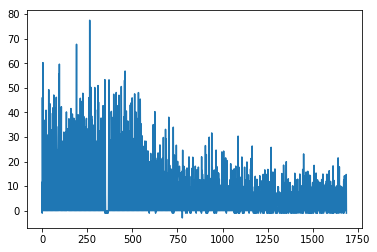

In [42]:
dataset = dataset.loc[dataset['store_nbr']==2, ['unit_sales','day']].fillna(-1)
dataset = dataset.reset_index(drop=True)
dataset_backup = dataset
plt.plot(pd.Series(range(0,len(dataset['unit_sales']))), dataset['unit_sales'])
plt.show()

In [43]:
dataset = dataset.values
dataset = dataset.astype('float32')
shape_tuple = dataset.shape

In [44]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [45]:
#Train/Test split:
train_len = int(0.67 * len(dataset))
test_size = len(dataset) - train_len
train, test = dataset[0:train_len,:], dataset[train_len:len(dataset),:]

In [46]:
trainX, trainY = create_dataset(train, 30)
testX, testY = create_dataset(test,30)

In [47]:
trainX.shape

(1099, 30, 2)

###Model

In [69]:
model = Sequential()
model.add(LSTM(20, input_shape=(30,2)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 20, batch_size=1, verbose = 1)

Epoch 1/20
1099/1099 [==============================] - 11s 10ms/step - loss: 0.0265
Epoch 2/20
1099/1099 [==============================] - 10s 9ms/step - loss: 0.0218
Epoch 3/20
1099/1099 [==============================] - 12s 11ms/step - loss: 0.0201
Epoch 4/20
1099/1099 [==============================] - 11s 10ms/step - loss: 0.0188
Epoch 5/20
1099/1099 [==============================] - 13s 12ms/step - loss: 0.0160
Epoch 6/20
1099/1099 [==============================] - 11s 10ms/step - loss: 0.0137
Epoch 7/20
1099/1099 [==============================] - 10s 9ms/step - loss: 0.0128
Epoch 8/20
1099/1099 [==============================] - 10s 9ms/step - loss: 0.0127
Epoch 9/20
1099/1099 [==============================] - 10s 9ms/step - loss: 0.0122
Epoch 10/20
1099/1099 [==============================] - 10s 9ms/step - loss: 0.0119
Epoch 11/20
1099/1099 [==============================] - 10s 9ms/step - loss: 0.0119
Epoch 12/20
1099/1099 [==============================] - 10s 9ms/step

In [70]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = invert_predictions(trainPredict, shape_tuple, scaler)
testPredict = invert_predictions(testPredict, shape_tuple, scaler)

In [71]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18.38 RMSE
Test Score: 8.14 RMSE


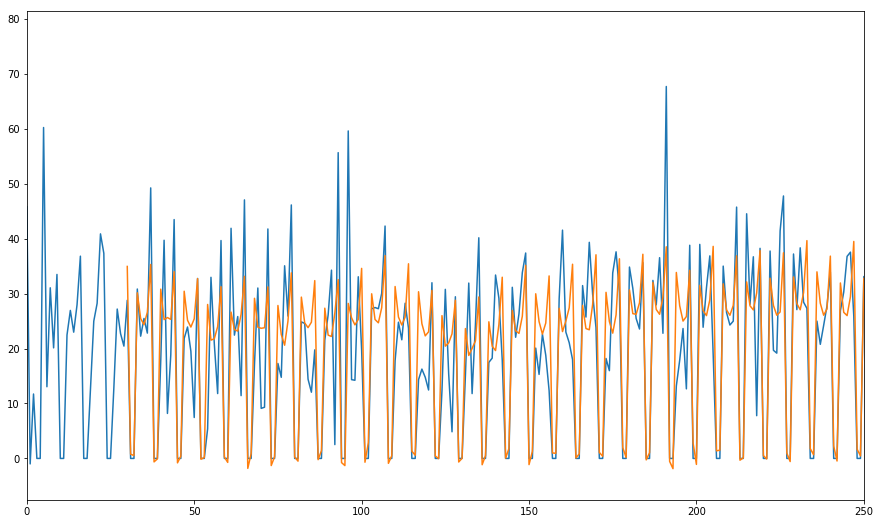

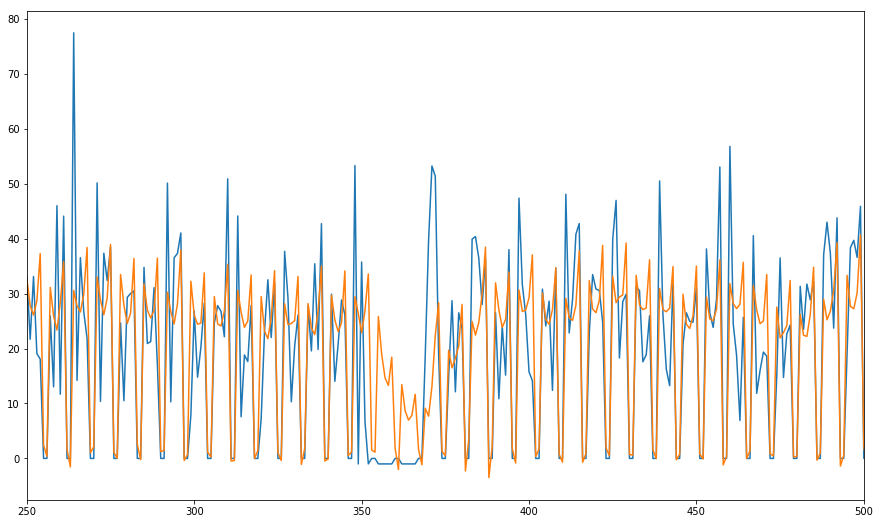

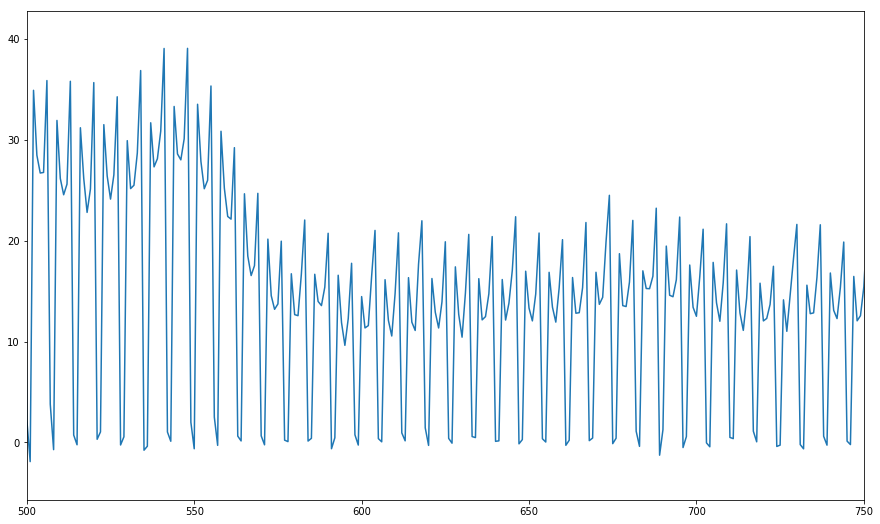

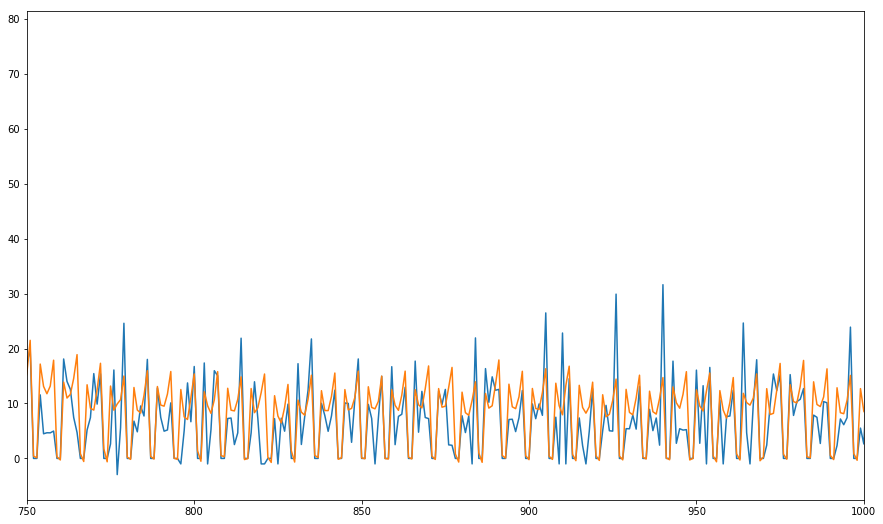

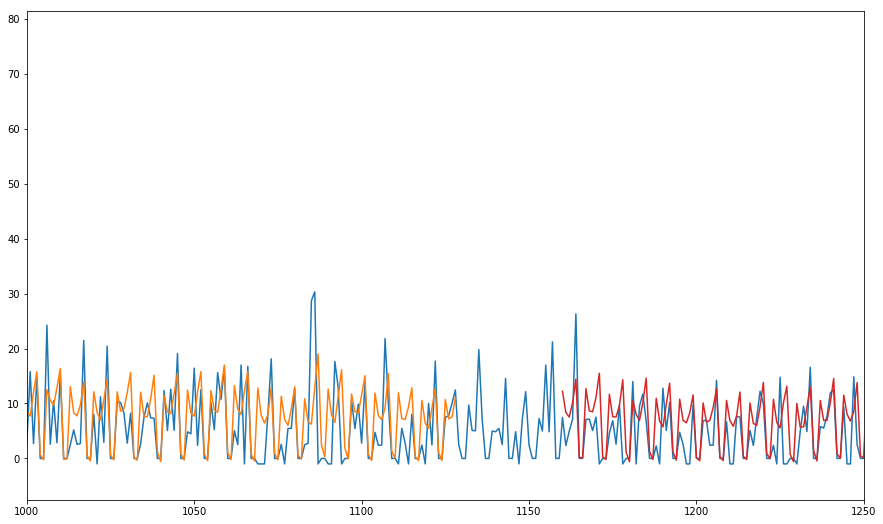

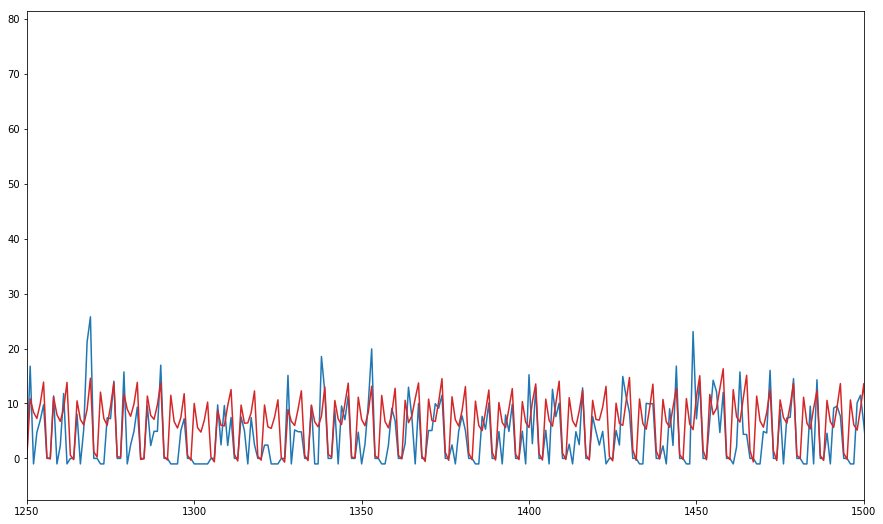

In [72]:
look_back = 30
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 0] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, 0] = testPredict
# plot baseline and predictions

plt.rcParams["figure.figsize"] = (15,9)
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(0,250)
plt.show()
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(250,500)
plt.show()
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(500,750)
plt.show()

plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(750,1000)
plt.show()
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(1000,1250)
plt.show()
plt.plot(dataset_backup.loc[:,['unit_sales']].values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlim(1250,1500)
fig = plt.figure(figsize=(50, 16))
plt.show()